# Simple Linear Regression Model

## Data Import

In [33]:
# Modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import sklearn
import numpy as np

dfRaw = pd.read_csv('../Data/housingNoMissing.csv')
dfRaw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## One Hot Encoding
*Should I be dropping one of the columns of the encoding to avoid multicollinearity?*

In [10]:
#df = pd.get_dummies(dfRaw, columns=['ocean_proximity'])
#df.head()


def oneHotEncoding(df):
    """One Hot Encoding for a specific column in a dataframe.
    columnName: str
    df: pandas DataFrame
    """
    categoricalColumns = df.select_dtypes(include=['object']).columns.tolist()
    encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
    encodedArray = encoder.fit_transform(df[categoricalColumns])

    encodedDf = pd.DataFrame(encodedArray, columns=encoder.get_feature_names_out(categoricalColumns))
    df = pd.concat([df, encodedDf], axis=1)
    df = df.drop(columns=categoricalColumns)
    return df

df = oneHotEncoding(dfRaw)

## Test-Train Split

In [14]:
dfTest, dfTrain = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)

## Linear Model
Ordinary least squares

### Training

- on all data $r^2 = 0.646$

In [19]:
reg = sklearn.linear_model.LinearRegression().fit(dfTrain.drop(columns=['median_house_value']), dfTrain['median_house_value'])

print('r^2 value:', reg.score(dfTest.drop(columns=['median_house_value']), dfTest['median_house_value']))

r^2 value: 0.6462709340520585


### Testing

Mean Absolute Error: 49985.45185934857
Mean Squared Error: 4728573082.358337
Predictions < $0: 33
Predictions > $500,000: 123


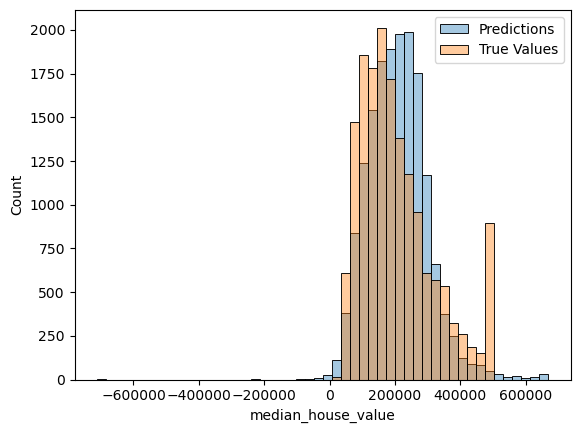

In [38]:
testPredicitions = reg.predict(dfTest.drop(columns=['median_house_value']))

fig, ax1 = plt.subplots()
bin_edges = np.linspace(min(dfTest['median_house_value'].min(), testPredicitions.min()),
                       max(dfTest['median_house_value'].max(), testPredicitions.max()),
                       51)  # 50 bins, 51 edges

sns.histplot(testPredicitions, bins=bin_edges, label='Predictions', kde=False, alpha=0.4, ax=ax1)
sns.histplot(dfTest['median_house_value'], bins=bin_edges, label='True Values', kde=False, alpha=0.4, ax=ax1)

ax1.legend()


print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(dfTest['median_house_value'], testPredicitions))
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(dfTest['median_house_value'], testPredicitions))

print('Predictions < $0:', (testPredicitions < 0).sum())
print('Predictions > $500,000:', (testPredicitions > 500000).sum())

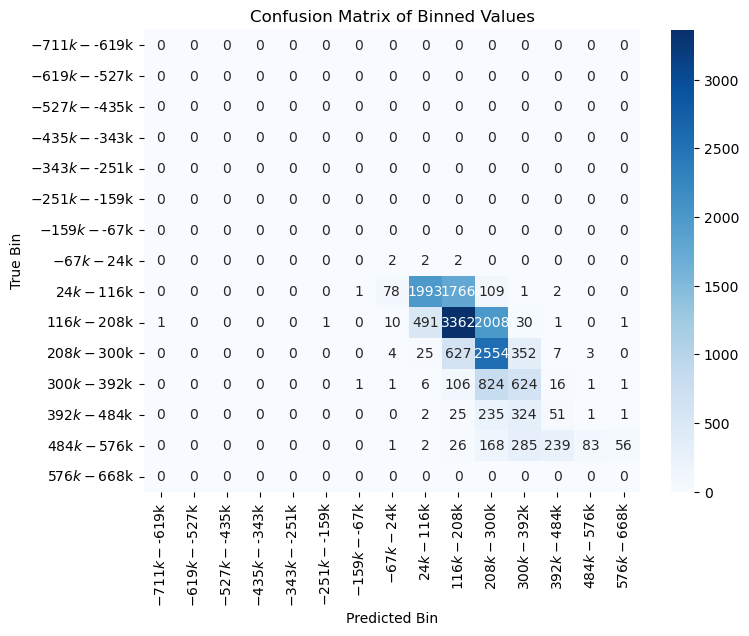

In [48]:
bin_edges = np.linspace(
    min(dfTest['median_house_value'].min(), testPredicitions.min()),
    max(dfTest['median_house_value'].max(), testPredicitions.max()),
    16  # 10 bins, 11 edges
)

# Bin the true and predicted values
true_bins = np.digitize(dfTest['median_house_value'], bin_edges) - 1
pred_bins = np.digitize(testPredicitions, bin_edges) - 1

# Clip indices to valid range
n_bins = len(bin_edges) - 1
true_bins = np.clip(true_bins, 0, n_bins - 1)
pred_bins = np.clip(pred_bins, 0, n_bins - 1)

# Compute confusion matrix with all bin labels
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_bins, pred_bins, labels=np.arange(n_bins))

# Create bin labels formatted in thousands of dollars, e.g. "$100k-$200k"
bin_labels = [f"${int(bin_edges[i]//1000)}k-${int(bin_edges[i+1]//1000)}k" for i in range(n_bins)]

# Plot confusion matrix with bin labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=bin_labels, yticklabels=bin_labels)
plt.xlabel('Predicted Bin')
plt.ylabel('True Bin')
plt.title('Confusion Matrix of Binned Values')
plt.show()


## Analysis
As expected it performs poorly as a basic linear model
- predicts negative prices and greater than max given in the data
- distritisation to make a confusion matrix is a useful presentation of what predictions is going wrong
- should investigate how $r^2$ varies with feeding more or less data into the model